### Alzheimer Disease Classifier

In [1]:
#Importing Statements.
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Constants.
Image_size = 128  #As the dimension of each image is 256x256 pixels
Batch_size = 32   #At any instant, we are processing 32 images i.e size of batch = 32 images
RGB_Channels = 3  #We know any image is represented using 3 channels, i.e R(Red), G(Green), B(Blue)
Epochs = 230

In [3]:
#Converting the images folder into the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory("Dataset", shuffle=True, image_size=(Image_size,Image_size), batch_size=Batch_size)

Found 6400 files belonging to 4 classes.


In [4]:
#All the classnames of dataset (i.e each image will be classified in the following outputs).
classnames = dataset.class_names
classnames

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

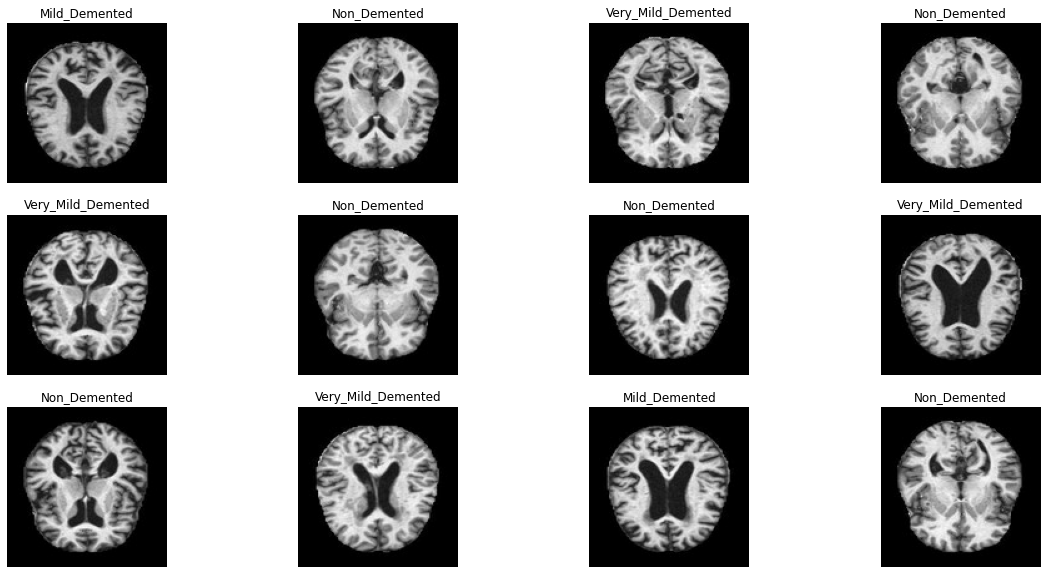

In [5]:
#Showing images from dataset using imshow() method.
plt.figure(figsize=(20,10))
for image, label in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.title(classnames[label[i]])
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis("off")

##### Train-Test Split


In [6]:
def division_of_dataset(ds, training_ratio=0.8, validation_ratio=0.1, testing_ratio = 0.1):
    '''Now dividing our data in train, test and validation set. 80%==>Training, 10%==>Validation and 10%==>Testing by default.
    Firstly calculating sizes of each set according to the ratio, then using ds.take(), ds.skip() methods to get the datasets.
    '''
    dataset_size = len(ds)
    train_size = int(training_ratio * dataset_size)
    val_size = int(validation_ratio * dataset_size)
    test_size = int(testing_ratio * dataset_size)
    training_set = ds.take(train_size)               # same as ds[:train_Size]
    val_set = ds.skip(train_size).take(val_size)     # same as ds[train_Size:val_size]
    test_set = ds.skip(train_size).skip(val_size)    # same as ds[val_size:]
    return training_set, val_set, test_set
train_set, val_set, test_set = division_of_dataset(dataset)

##### Optimizing the datasets

In [7]:
#The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch. 
#The next epochs will reuse the data cached by the cache transformation.
#Prefetch overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. 
#Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

##### Scaling/Normalizing the arrays

In [8]:
#When we supply the external input to the model, it will automatically resize and rescale the image.
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/128)])

##### Data Augmentation

In [9]:
#It makes the model robusts by predicting the result if the image is contrast, flipped, rotated.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])

##### Model Developement

In [10]:
#The total image size is (32, 128, 128, 3) and number of classes(outputs) are 4
Img_size = (Batch_size, Image_size, Image_size, RGB_Channels)
Number_of_classes = len(classnames)
model = keras.Sequential([
    resize_and_rescale,                            #Normalizing layer
    data_augmentation,                             #Data Augmentation layer
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu',input_shape =Img_size), #increase the layers on trial and error
    tf.keras.layers.MaxPool2D((2,2)), 
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu',input_shape =Img_size),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu',input_shape =Img_size),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu',input_shape =Img_size),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(Number_of_classes, activation = 'softmax'),
])
model.build(input_shape=Img_size)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 63, 63, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 30, 30, 64)         0         
 2D)                                                  

In [12]:
#Compile defines the loss function, the optimizer and the metrics. 
#Loss function is used to find error or deviation in the learning process. Keras requires loss function during model compilation process.
#Optimization is an important process which optimize the input weights by comparing the prediction and the loss function. 
#Metrics is used to evaluate the performance of your model. It is similar to loss function, but not used in training process. 
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [13]:
#Fitting(Training) the model
model.fit(train_set, epochs=Epochs,batch_size=Batch_size,verbose = 1, validation_data=val_set)

Epoch 1/230
160/160 [==============================] - 117s 518ms/step - loss: 1.0479 - accuracy: 0.4865 - val_loss: 1.0678 - val_accuracy: 0.4906
Epoch 2/230
160/160 [==============================] - 50s 312ms/step - loss: 1.0101 - accuracy: 0.5061 - val_loss: 0.9722 - val_accuracy: 0.5641
Epoch 3/230
160/160 [==============================] - 50s 312ms/step - loss: 0.9497 - accuracy: 0.5381 - val_loss: 0.9216 - val_accuracy: 0.5781
Epoch 4/230
160/160 [==============================] - 49s 304ms/step - loss: 0.9263 - accuracy: 0.5422 - val_loss: 0.9497 - val_accuracy: 0.5797
Epoch 5/230
160/160 [==============================] - 50s 310ms/step - loss: 0.9048 - accuracy: 0.5580 - val_loss: 0.9351 - val_accuracy: 0.5719
Epoch 6/230
160/160 [==============================] - 52s 325ms/step - loss: 0.8979 - accuracy: 0.5605 - val_loss: 0.9203 - val_accuracy: 0.5719
Epoch 7/230
160/160 [==============================] - 51s 316ms/step - loss: 0.8830 - accuracy: 0.5607 - val_loss: 0.9298 

In [15]:
#Checking accuracy by evaluating the model using test dataset
model.evaluate(test_set)

20/20 [==============================] - 10s 78ms/step - loss: 0.7834 - accuracy: 0.7297


[0.7833672761917114, 0.729687511920929]

In [8]:
#Saving the model
#saved_model = model.save('./MyModel_h5.h5', save_format='h5')
load_model = tf.keras.models.load_model('./MyModel_h5.h5')
#load_model.fit(train_set, epochs=30,batch_size=Batch_size,verbose = 1, validation_data=val_set)

first image to predict
actual label: Non_Demented
1/1 [==============================] - 0s 86ms/step
predicted label: Non_Demented


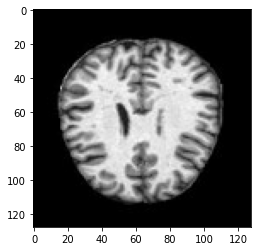

In [13]:
#Checking prediction
import numpy as np
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classnames[first_label])
    
    batch_prediction = load_model.predict(images_batch)
    print("predicted label:",classnames[np.argmax(batch_prediction[0])])